
# 1. Libraries setup

### Import the fastai library

In [1]:
from fastai.transforms import *
from fastai.conv_learner import *
from fastai.model import *
from fastai.dataset import *
from fastai.sgdr import *
from fastai.plots import *

### Import all the other libraries needed

In [2]:
import os # Create directories, list files
import zipfile # Extract compressed files
import numpy as np # Linear algebra, sorting and selecting
import pandas as pd # Dataframes and csv I/O
import matplotlib.pyplot as plt # Plotting histograms
from math import exp

<br>
<br>
# 2. Environment setup

### Environment

```
./input
│   train.csv    
│
└─── train
│   │   train_whale1.jpg
│   │   train_whale2.jpg
│   
│   
└─── test
│   │   test_whale1.jpg
│   │   test_whale2.jpg
│  
│   
└─── submission
    │   submission1.csv
    │   submission2.csv
```

### Initialize the enviroment variables

In [3]:
INPUT_DIR = ".\input"
DOWNLOAD_DIR = "C:\\Users\\David\\.kaggle\\competitions\\whale-categorization-playground"

### Download the data from kaggle

Instructions to use the kaggle API: https://github.com/Kaggle/kaggle-api

In [4]:
if (os.system("kaggle competitions download -c whale-categorization-playground") == 0): print("Compressed files ready")

Compressed files ready


### Extract the data to the input directory

In [5]:
os.listdir(DOWNLOAD_DIR)

print("Extracting the training set...")
train_zip = zipfile.ZipFile(DOWNLOAD_DIR+"\\train.zip", mode="r")
train_zip.extractall(INPUT_DIR)
train_zip.close()

print("Extracting the test set...")
test_zip = zipfile.ZipFile(DOWNLOAD_DIR+"\\test.zip", mode="r")
test_zip.extractall(INPUT_DIR)
test_zip.close()

print("All files extracted succesfully")

Extracting the training set...
Extracting the test set...
All files extracted succesfully


### Move the train.csv file and create the submission directory

In [6]:
if not os.path.exists(INPUT_DIR+"\\train.csv"):
    os.rename(DOWNLOAD_DIR+"\\train.csv", INPUT_DIR+"\\train.csv")
print("train.csv ready")
    
if not os.path.exists(INPUT_DIR+"\\submission"): 
    os.mkdir(INPUT_DIR+"\\submission")
print("sumbmission directory ready")

train.csv ready
sumbmission directory ready


### Check everything is correct

In [7]:
expected_dir = ['submission','train',  'test', 'train.csv']
current_dir = os.listdir(INPUT_DIR)
print(current_dir)
if set(expected_dir).issubset(set(current_dir)): print("Everything is correct")

['models', 'prova', 'submission', 'test', 'tmp', 'train', 'train.csv']
Everything is correct


<br>
<br>
# 3. Data exploration

<br>
## 3.1 Training dataframe

### Training dataframe creation

Generate the pandas dataframe that will link each image to the corresponding whale from the csv file.
Show some basic info.

In [8]:
train_df = pd.read_csv(INPUT_DIR + "/train.csv")
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9850 entries, 0 to 9849
Data columns (total 2 columns):
Image    9850 non-null object
Id       9850 non-null object
dtypes: object(2)
memory usage: 154.0+ KB


### Training dataframe structure


As we can see we have two columns, corresponding to the whale image path and the whale identifier.

In [9]:
train_df.head()

,Image,Id
0,00022e1a.jpg,w_e15442c
1,000466c4.jpg,w_1287fbc
2,00087b01.jpg,w_da2efe0
3,001296d5.jpg,w_19e5482
4,0014cfdf.jpg,w_f22f3e3


<br>
## 3.2 Training data visualitzation

### Welcoming whale

Load a random whale image to welcome us.

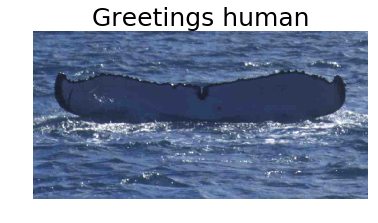

In [10]:
welcoming_whale = train_df.sample(1)["Image"].values[0]
image = plt.imread(f'{INPUT_DIR}/train/{welcoming_whale}')
image_plot = plt.imshow(image)
plt.axis("Off")
title = plt.title("Greetings human", fontsize=25)


<br>
### Training set images visualitzation

Create a function to retrieve n random whales from the dataset.

In [11]:
def get_random_whales(n):
    """Returns iterable of n lists of random whale images and whale id pairs from the training dataset
        [img_name1, img1], [img_name2, img2], ..., [img_name3, img3]
    """
    train_sample = train_df.sample(n)
    identifiers = [whale_id for whale_id in train_sample["Id"]]
    images = [plt.imread(f'{INPUT_DIR}/train/{image_name}')  for image_name in train_sample["Image"]]
    whales = zip(identifiers, images)
    return whales

<br>
Create a function to display n whales with the corresponding identifier.

In [12]:
def plot_random_whales(n):
    """Plots n random whales with its corresponding identifier
    """
    whales = get_random_whales(n)
    columns = 5
    rows = (n // columns) + 1
    width, height = columns * 3, rows * 3
    figure = plt.figure(figsize=(width,height))
    for i, whale in enumerate(whales):
        subplot = figure.add_subplot(rows,columns,i+1)
        subplot.axis("Off")
        plt.title(whale[0])
        plt.imshow(whale[1])

<br>
Let's see some whales

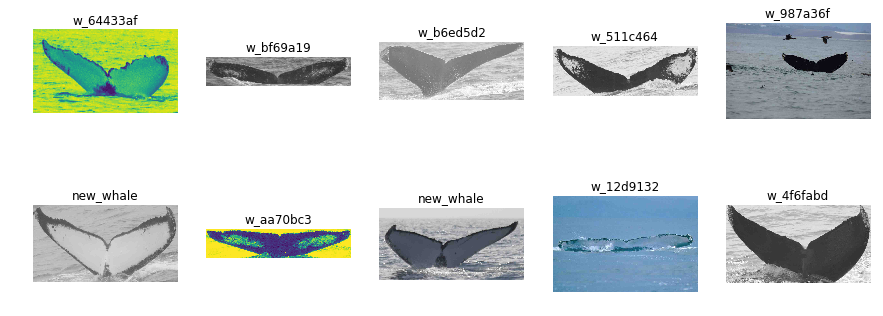

In [13]:
plot_random_whales(10)

<br>
## 3.3 Training data analysis

### Number of training examples and categories

In [30]:
n_train_images = train_df["Image"].count()
categories = train_df["Id"].unique()
n_categories = len(train_df["Id"].unique())
ratio_images_per_category = round(n_train_images / n_categories, 2)
print(f"Number of training images: {n_train_images}")
print(f"Number of categories: {n_categories}")
print(f"Average images per category: {ratio_images_per_category}")

Number of training images: 9850
Number of categories: 4251
Average images per category: 2.32


As we can see, we don't have many test cases per category. We will use a histogram to visualize it better.

<br>
## Histogram:
### Number of images per category

We count the number of images each category has (images_per_category). <br>
We compute the pair of lists:
 - number of images
 - number of categories with that number of images.

In [15]:
images_per_category = train_df["Id"].value_counts().values
n_images, n_categories_with_n_images = np.unique(images_per_category, return_counts=True)

Plot the corresponding histogram

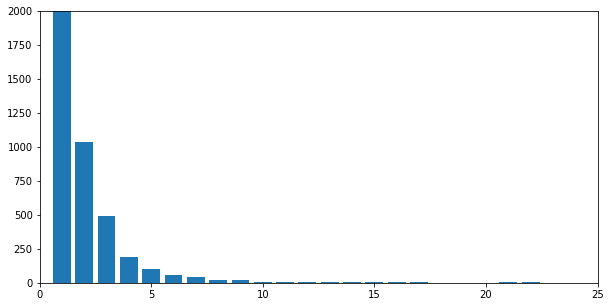

In [16]:
plt.figure(figsize=(10, 5))
plt.bar(n_images, n_categories_with_n_images)
plt.axis((0,25,0,2000))
plt.show()

One huge problem with this dataset is the number of images per category.
 - First, it's very hard to generalize from such small number of cases
 - Second, if we include all the images for one particular category in the validation set, then our trained network won't have the right output dimensionality (this will break our model as we will see later)

<br>
<br>
# 4. Neural net training

Building a succesfull neural network is an iterative process. We shouldn't expect to come up with a magical idea that will make a great network from the start. Also we shouldn't make decisions based on "gut feelings" or "divine visions".

<br>
## 4.1 First iteration: Basic Model

My first priority is to build a basic and dirty classfier that will output something.
That something doesn't have to be great, it can be just above garbage, but thats more than enough to extract some metrics that will drive our decisions much better.
For that reason, I won't bother for augmentations, tricky algorithms or anything more than the very basics at this point. I will just focus on predicting something I can upload to kaggle.

### Architecture
The chosen architecture is resnet34, it comes pretrained with a huge imagenet dataset and it's not too complex.

In [22]:
arch = resnet34

### Transformations size
Resnet34 was trained on mostly 224·224 to 300·300 images sizes. For that reason, transforming the training images to that size should result in decent result.

In [23]:
tfms = tfms_from_model(arch, 224)

### Validation set
For now, we will go with the standard 20% of the training set

In [31]:
val_idxs = get_cv_idxs(n_train_images, val_pct=0.2)

### Data preprocessing
Now we can adapt the training set images to train a neural net based on the previous options.<br>
We don't have folders for each category so we will create the data from the csv file.

In [32]:
data = ImageClassifierData.from_csv(path="./input", folder="train", val_idxs=val_idxs, csv_fname="./input/train.csv", test_name="test", skip_header=True, tfms=tfms)

### Learning rate
Create a pretrained convolutional neural network instance. 

In [33]:
learn = ConvLearner.pretrained(arch, data, precompute=True)

Compute the learning rate related info

In [38]:
learn.lr_find()

 82%|████████▏ | 102/124 [00:01<00:00, 88.24it/s, loss=101] 


Our learning instance has a scheduler that exponentially increases the learning rate with each batch.<br>
Let's plot how this sheduler increses the learning rate with each iteration.

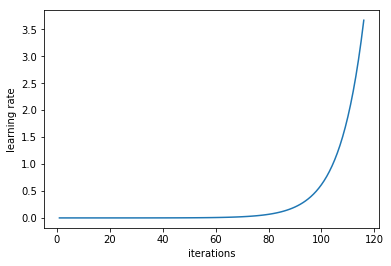

In [40]:
learn.sched.plot_lr()

Check how the loss decreases faster for a bigger learning rate until it becomes unstable.

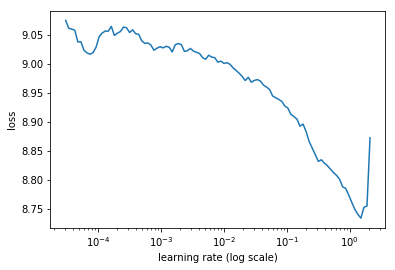

In [41]:
learn.sched.plot()

A learning rate of 0.1 seems like a reasonable choice.

### Model training
Train the model with the chosen learning rate for 2 epochs or cycles.

In [43]:

learn.fit(lrs=0.1, n_cycle=2)

epoch      trn_loss   val_loss   accuracy                    
    0      7.95144    7.586028   0.082722  
    1      6.845615   7.314001   0.093085                    



[7.314001, 0.09308467733283196]

<br>
<br>
# 5. Neural net predictions

We set the is_test flag to True to tell the model to predict on the test set.<br>
learn.predict() outputs the logarithm of the output of the last layer for each category.

So, the output ranges from 0 to 1:<br>
0 corresponds to a very unlikely match<br>
1 corresponds to a almost certain match

Applying a logarithm to the activation value we get an output that ranges from -inf to 0:<br>
-inf corresponds to a very unlikely match<br>
0 corresponds to a almost certain match


Taking this into consideration we can now compute the prediction for one image of the test set.<br>
The prediction is represented as an array of the logarithms of the activations for each of the categories  sorted in the appearing order in the csv file.<br>
In this case, the model has 4250 categories, so the output will be an array of 4250 items.<br>
[-7.12, -8.23, -3.89, ... ,-10.67] --> len(one_prediction) == 4250

So the prediction for m test cases will result in a list of the predictions of each image for each category.<br>
It can be thought as a m*c matrix


In [44]:
test_name = "test"
log_predictions_test = learn.predict(is_test=True)

In this kaggle competition we are told to give the 5 more likely categories for each test case.
We extract the 5 highest values (closest to 0) and the corresponding category indexes for each test case prediction.
Now we match the indexes with the category name from the original "Id" column of the dataframe.
Finally, we write our predictions in a csv file.


In [45]:
def categories_wrapper(prediction):
    case_predicted_categories = np.argpartition(prediction, -5)[-5:]
    return case_predicted_categories

In [47]:
type(log_predictions_test)
print(len(log_predictions_test[5]))
print(log_predictions_test[0][4249])
#np.argpartition(log_predictions_test[0], -5)[-5:]
predicted_categories = list(map(categories_wrapper, log_predictions_test))
print(predicted_categories[4210])

4250
-10.310118
[4183 1769 1325 2620    0]


In [184]:
def categories_from_index(prediction):
    pred_cat = []
    for index in prediction:
        pred_cat.append(categories[index])
    return pred_cat
    

In [185]:
predicted_cat = list(map(categories_from_index, predicted_categories))
predicted_cat[3]


['w_80171b9', 'w_dd52cfc', 'w_6dd7c3d', 'w_01a4234', 'w_e15442c']

In [186]:
predicted_format_df = list(map(" ".join, predicted_cat))
print(predicted_format_df[1000])
list_name_test_images = os.listdir("./input/test")
predictions_df  = pd.DataFrame(data = {"Image":list_name_test_images, "Id": predicted_format_df}, columns=["Image", "Id"])
predictions_df.to_csv("submission2.csv",index=False)

w_4457d27 w_e15442c w_578a509 w_6d7c852 w_14c8f15
